# Create Patches from CIFAR-100 for Fixup-Arch

In [1]:
#from google.colab import files
#files.upload()

In [2]:
! ls

imgrepr-0.0.1-cp36-cp36m-linux_x86_64.whl  sample_data


In [3]:
! pip uninstall imgrepr -y
! pip install imgrepr-0.0.1-cp36-cp36m-linux_x86_64.whl

Uninstalling imgrepr-0.0.1:
  Successfully uninstalled imgrepr-0.0.1
Processing ./imgrepr-0.0.1-cp36-cp36m-linux_x86_64.whl


In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy
import sklearn
import platform
import matplotlib
import pickle
import torch
import torchvision
import umap
import PIL

print('python version:      {}'.format(platform.python_version()))
print('sklearn version:     {}'.format(sklearn.__version__))
print('umap version:        {}'.format(umap.__version__))
print('numpy version:       {}'.format(numpy.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('PIL version:         {}'.format(PIL.__version__))

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torchvision import transforms
from imgrepr.image_patch import ImagePatchExtractor
from imgrepr.image_keypoint import ImageKeyPoint
from collections import Counter

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

python version:      3.6.9
sklearn version:     0.22.2.post1
umap version:        0.4.6
numpy version:       1.18.5
matplotlib version:  3.2.2
pickle version:      4.0
torch version:       1.6.0+cu101
torchvision version: 0.7.0+cu101
PIL version:         7.0.0.post3


Mount GDrive:

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
base_url = '/content/gdrive/My Drive/neuralnet-patchinit/results/'

## Load Data

Define data transform functions:

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()
])

Define training set:

In [9]:
trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)

Extracting ./data/cifar-100-python.tar.gz to ./data


Create train data loader:

In [10]:
batch_size = 15500

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

## Create Patches

In [11]:
def get_patches_from_batch(batch):
    patches = []
    for sample in batch:
        sample_patches = get_patches(sample)

        if sample_patches.shape[0] != 0:
            patches.append(sample_patches)

    return np.vstack(patches)


def get_patches(sample):
    image_rgb = np.moveaxis(sample, 0, -1)

    if np.max(image_rgb) != 0:
        image_rgb = (image_rgb * 255) / np.max(image_rgb)

    image_rgb = image_rgb.astype('uint8')
    
    patch_extractor = ImagePatchExtractor(7)
    patches = patch_extractor.get_keypoint_patches(image_rgb, "SIFT", 9, 5)

    patches = list(map(lambda p: np.moveaxis(p, 2, 0), patches))
    patches = list(map(lambda p: p.flatten(), patches))
    patches = list(map(lambda p: (p / 255.0).astype(np.double), patches))

    if not patches:
      return np.array([])

    return np.vstack(patches)


def show_sample(data):
    print("tensor shape: " + str(data.shape))
    print("min:          " + str(np.amin(data)))
    print("max:          " + str(np.amax(data)))
    
    fig = plt.figure()
    patch = np.moveaxis(data, 0, -1)
    plt.imshow(patch, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])


def show_patches(patches):
    print("tensor shape: " + str(patches.shape))
    
    fig = plt.figure(figsize=(8,8))
    for i in range(patches.shape[0]):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        patch = np.moveaxis(patches[i], 0, -1)
        plt.imshow(patch, cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])

Extract patches from samples:

In [12]:
patch_data = []
sample_patch_data = None
test_sample = None

for batch_idx, (batch_data, batch_target) in enumerate(trainloader):
    batch_np = batch_data.detach().numpy()

    batch_patches = get_patches_from_batch(batch_np)
    patch_data.append(batch_patches)

    if batch_idx == 0:
        sample_patch_data = batch_patches
        test_sample = batch_np[0]


patch_data = np.vstack(patch_data)

print("total patches:  {}".format(patch_data.shape))
print("sample patches: {}".format(sample_patch_data.shape))

total patches:  (155395, 675)
sample patches: (48085, 675)


Show patches of first sample:

tensor shape: (9, 3, 15, 15)


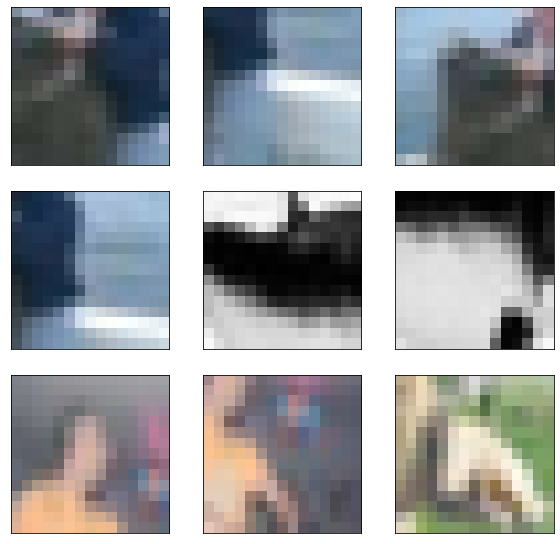

In [13]:
sample_patches = patch_data[0:9].reshape(9, 3, 15, 15)
show_patches(sample_patches)

Show test sample:

tensor shape: (3, 32, 32)
min:          0.07058824
max:          1.0


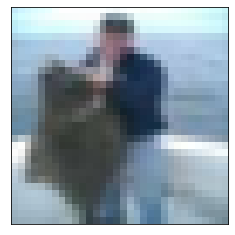

In [14]:
show_sample(test_sample)

## Cluster Patch Data

In [15]:
def show_center_patches(patches):
    print("tensor shape: " + str(patches.shape))
    
    fig = plt.figure(figsize=(8,8))
    for i in range(patches.shape[0]):
        plt.subplot(4,4,i+1)
        plt.tight_layout()
        patch = np.moveaxis(patches[i], 0, -1)
        plt.imshow(patch, cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])

In [16]:
patches_layer1_pca_path       = 'patches-cifar100-fixup-layer1-pca-kmeans.txt'
patches_layer1_pca_avg_path   = 'patches-cifar100-fixup-layer1-pca-kmeans-avg.txt'
patches_layer1_umap_path      = 'patches-cifar100-fixup-layer1-umap-kmeans.txt'
patches_layer1_umap_avg1_path = 'patches-cifar100-fixup-layer1-umap-kmeans-avg1.txt'
patches_layer1_umap_avg2_path = 'patches-cifar100-fixup-layer1-umap-kmeans-avg2.txt'
patches_layer2_pca_path       = 'patches-cifar100-fixup-layer2-pca-kmeans.txt'
patches_layer2_pca_avg_path   = 'patches-cifar100-fixup-layer2-pca-kmeans-avg.txt'
patches_layer2_umap_path      = 'patches-cifar100-fixup-layer2-umap-kmeans.txt'
patches_layer2_umap_avg1_path = 'patches-cifar100-fixup-layer2-umap-kmeans-avg1.txt'
patches_layer2_umap_avg2_path = 'patches-cifar100-fixup-layer2-umap-kmeans-avg2.txt'
patches_layer3_pca_path       = 'patches-cifar100-fixup-layer3-pca-kmeans.txt'
patches_layer3_pca_avg_path   = 'patches-cifar100-fixup-layer3-pca-kmeans-avg.txt'
patches_layer3_umap_path      = 'patches-cifar100-fixup-layer3-umap-kmeans.txt'
patches_layer3_umap_avg1_path = 'patches-cifar100-fixup-layer3-umap-kmeans-avg1.txt'
patches_layer3_umap_avg2_path = 'patches-cifar100-fixup-layer3-umap-kmeans-avg2.txt'
patches_layer4_pca_path       = 'patches-cifar100-fixup-layer4-pca-kmeans.txt'
patches_layer4_pca_avg_path   = 'patches-cifar100-fixup-layer4-pca-kmeans-avg.txt'
patches_layer4_umap_path      = 'patches-cifar100-fixup-layer4-umap-kmeans.txt'
patches_layer4_umap_avg1_path = 'patches-cifar100-fixup-layer4-umap-kmeans-avg1.txt'
patches_layer4_umap_avg2_path = 'patches-cifar100-fixup-layer4-umap-kmeans-avg2.txt'

Scale data:

In [17]:
scaler = StandardScaler()
patch_data_scaled = scaler.fit_transform(patch_data)
sample_patch_data_scaled = scaler.fit_transform(sample_patch_data)

### Using PCA

Reduce data to 2D using PCA:

In [18]:
pca = PCA(n_components=2)
patch_data_2d_pca = pca.fit_transform(patch_data_scaled); patch_data_2d_pca.shape

(155395, 2)

### Using UMAP

Reduce data to 2D using UMAP:

In [19]:
reducer = umap.UMAP()
patch_data_2d_umap = reducer.fit_transform(sample_patch_data_scaled); patch_data_2d_umap.shape

(48085, 2)

### Cluster Patches for 1st layer

In [20]:
num_clusters_layer1 = 16

#### Cluster PCA data

Apply kMeans:

In [21]:
kmeans_pca = KMeans(n_clusters=num_clusters_layer1, random_state=0).fit(patch_data_2d_pca)

Get the closest patch for each cluster center:

In [22]:
closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, patch_data_2d_pca)

tensor shape: (16, 3, 15, 15)


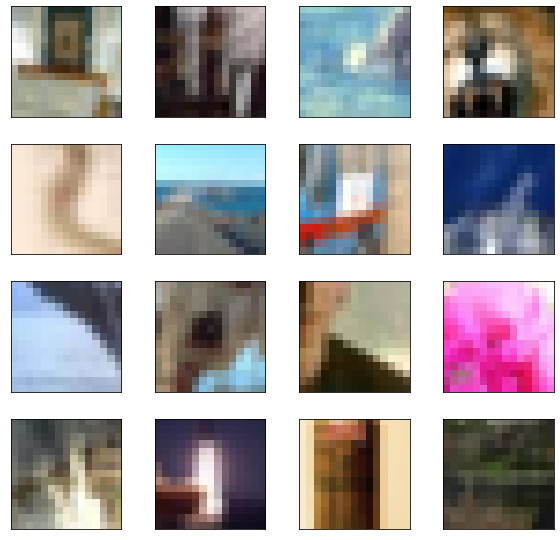

In [23]:
center_patches_pca = []

for c in closest_pca:
    temp_patch = patch_data[c].reshape(1, 3, 15, 15)
    center_patches_pca.append(temp_patch)

center_patches_pca = np.vstack(center_patches_pca)
show_center_patches(center_patches_pca)

Save found patches:

In [24]:
center_patches_pca.shape

(16, 3, 15, 15)

In [25]:
result_path_pca = base_url + patches_layer1_pca_path
with open(result_path_pca, "wb") as fp:
    pickle.dump(center_patches_pca, fp)

Get the k closest patches for each cluster center:

In [26]:
k = 10

In [27]:
distances_pca = pairwise_distances(kmeans_pca.cluster_centers_, patch_data_2d_pca); distances_pca.shape

(16, 155395)

In [28]:
nearest_idx_pca = np.argsort(distances_pca, axis=1)[:,:k]; nearest_idx_pca[:,0]

array([ 97678,   1142, 120925, 104963,  23258, 145128, 153373, 120026,
        41143,  74499,  35512,   5380,   5562,  39090,  39912,  50169])

Check if we really found the k closest clusters:

In [29]:
for i in range(kmeans_pca.cluster_centers_.shape[0]):
    center_distances = distances_pca[i][nearest_idx_pca[i]]
    farthest = max(center_distances)
    nearer_points = distances_pca[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


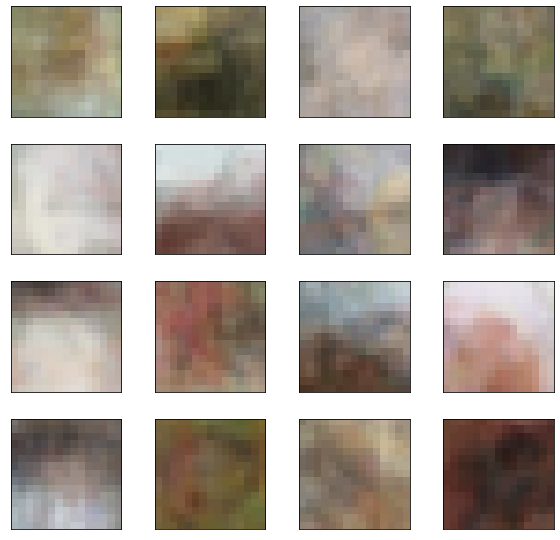

In [30]:
center_patches_avg_pca = []

for c in range(nearest_idx_pca.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_pca.shape[1]):
        temp_idx = nearest_idx_pca[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_pca.shape[1])
    center_patches_avg_pca.append(temp_patch)

center_patches_avg_pca = np.vstack(center_patches_avg_pca)
show_center_patches(center_patches_avg_pca)

Save found average patches:

In [31]:
center_patches_avg_pca.shape

(16, 3, 15, 15)

In [32]:
result_path_avg_pca = base_url + patches_layer1_pca_avg_path
with open(result_path_avg_pca, "wb") as fp:
    pickle.dump(center_patches_avg_pca, fp)

#### Cluster UMAP data

Apply kMeans:

In [33]:
kmeans_umap = KMeans(n_clusters=num_clusters_layer1, random_state=0).fit(patch_data_2d_umap)

Get the closest patch for each cluster center:

In [34]:
closest_umap, _ = pairwise_distances_argmin_min(kmeans_umap.cluster_centers_, patch_data_2d_umap)

tensor shape: (16, 3, 15, 15)


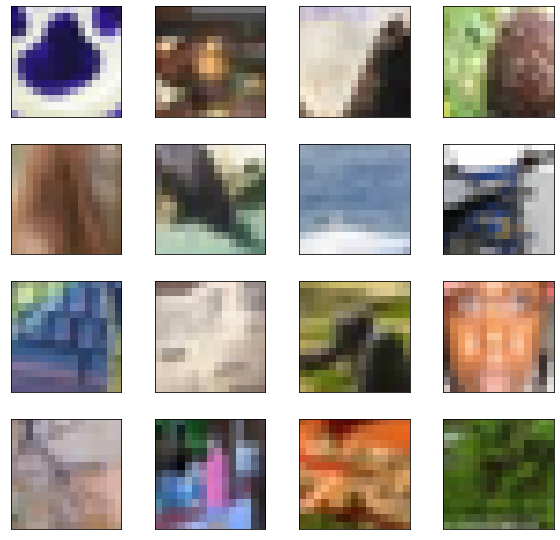

In [35]:
center_patches_umap = []

for c in closest_umap:
    temp_patch = patch_data[c].reshape(1,3,15,15)
    center_patches_umap.append(temp_patch)

center_patches_umap = np.vstack(center_patches_umap)
show_center_patches(center_patches_umap)

Save found patches:

In [36]:
center_patches_umap.shape

(16, 3, 15, 15)

In [37]:
result_path_umap = base_url + patches_layer1_umap_path
with open(result_path_umap, "wb") as fp:
    pickle.dump(center_patches_umap, fp)

Get the k closest patches for each cluster center:

In [38]:
k = 5

In [39]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(16, 48085)

In [40]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([31268,  7616, 17239, 42753, 36951, 35453, 38714, 32512, 43840,
       19642, 27652, 25899,  7574,    31, 29865, 12662])

Check if we really found the k closest clusters:

In [41]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


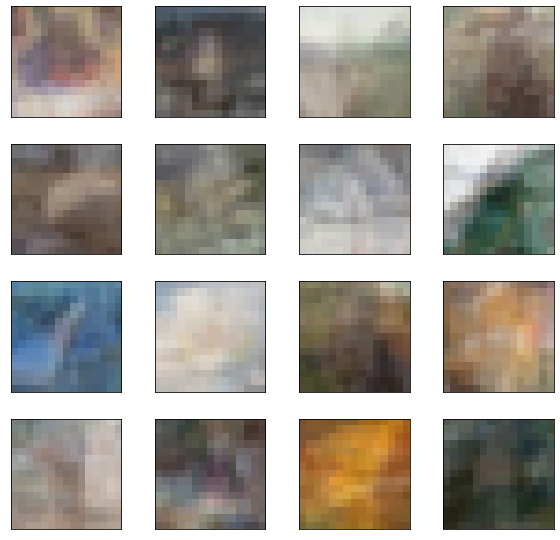

In [42]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap)

Save found average patches:

In [43]:
center_patches_avg_umap.shape

(16, 3, 15, 15)

In [44]:
result_path_avg_umap = base_url + patches_layer1_umap_avg1_path
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)

Get the k closest patches for each cluster center:

In [45]:
k = 10

In [46]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(16, 48085)

In [47]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([31268,  7616, 17239, 42753, 36951, 35453, 38714, 32512, 43840,
       19642, 27652, 25899,  7574,    31, 29865, 12662])

Check if we really found the k closest clusters:

In [48]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


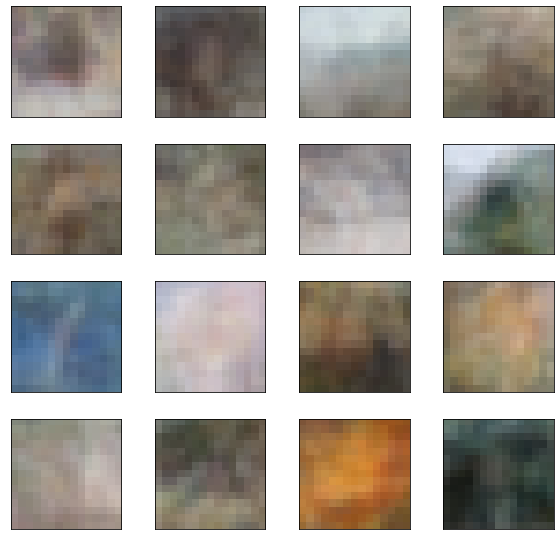

In [49]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap)

Save found average patches:

In [50]:
center_patches_avg_umap.shape

(16, 3, 15, 15)

In [51]:
result_path_avg_umap = base_url + patches_layer1_umap_avg2_path
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)

### Cluster Patches for 2nd layer

In [52]:
num_clusters_layer2 = 86

#### Cluster PCA data

Apply kMeans:

In [53]:
kmeans_pca = KMeans(n_clusters=num_clusters_layer2, random_state=0).fit(patch_data_2d_pca)

Get the closest patch for each cluster center:

In [54]:
closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, patch_data_2d_pca)

tensor shape: (16, 3, 15, 15)


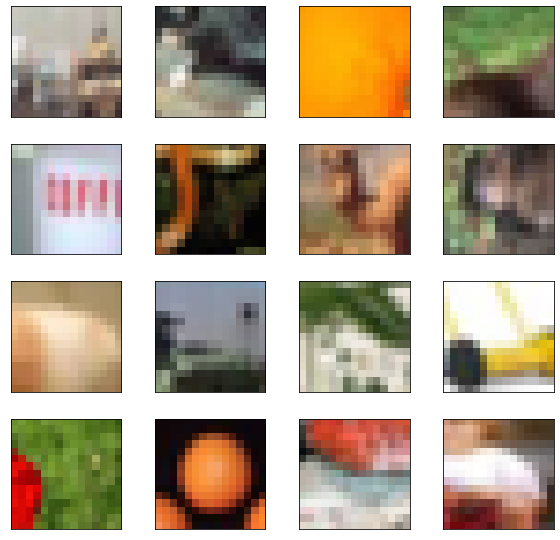

In [55]:
center_patches_pca = []

for c in closest_pca:
    temp_patch = patch_data[c].reshape(1, 3, 15, 15)
    center_patches_pca.append(temp_patch)

center_patches_pca = np.vstack(center_patches_pca)
show_center_patches(center_patches_pca[:16])

Save found patches:

In [56]:
center_patches_pca.shape

(86, 3, 15, 15)

In [57]:
result_path_pca = base_url + patches_layer2_pca_path
with open(result_path_pca, "wb") as fp:
    pickle.dump(center_patches_pca, fp)

Get the k closest patches for each cluster center:

In [58]:
k = 10

In [59]:
distances_pca = pairwise_distances(kmeans_pca.cluster_centers_, patch_data_2d_pca); distances_pca.shape

(86, 155395)

In [60]:
nearest_idx_pca = np.argsort(distances_pca, axis=1)[:,:k]; nearest_idx_pca[:,0]

array([ 30158,  79367, 148195, 117872,  80243,  99326,  73155,  62217,
         4231,  22023,  22956,   6038,  70805,   8881,  68851,  45680,
       118392,   2194, 149651, 141052,  45464, 145516,  87730,  40384,
        24218, 106535,  31287,  71232,   8012, 142410, 128388,  24734,
       153613,  70073,   1894,    851,  91332, 153604,  49970,  34338,
        13804,  52392, 117128,  72557,  94309,  50401, 102352, 148464,
       126196,  51736,  52274, 151647,   4072,  39535,  83562,  69997,
        61105,  51602,  13134,   1345,  45021,  27293, 123001, 131548,
       154585, 103755,  48526, 120887,  33687,  39533, 120641, 141896,
        21889,  91361,  77757,  29895,  97764,  41735,  62801,  91139,
       118011,  59723,   6726, 107654,   3610, 141616])

Check if we really found the k closest clusters:

In [61]:
for i in range(kmeans_pca.cluster_centers_.shape[0]):
    center_distances = distances_pca[i][nearest_idx_pca[i]]
    farthest = max(center_distances)
    nearer_points = distances_pca[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


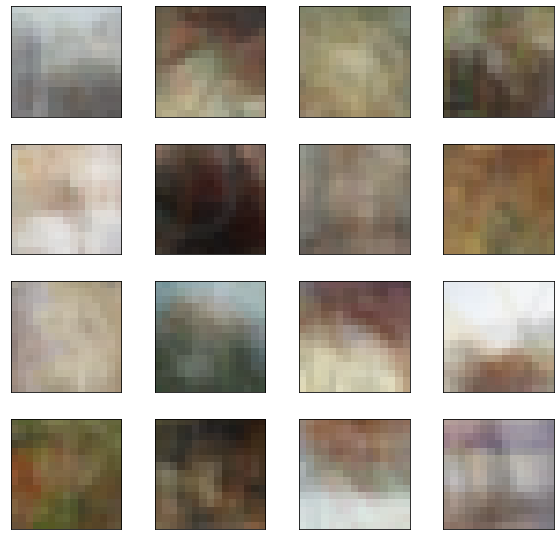

In [62]:
center_patches_avg_pca = []

for c in range(nearest_idx_pca.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_pca.shape[1]):
        temp_idx = nearest_idx_pca[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_pca.shape[1])
    center_patches_avg_pca.append(temp_patch)

center_patches_avg_pca = np.vstack(center_patches_avg_pca)
show_center_patches(center_patches_avg_pca[:16])

Save found average patches:

In [63]:
center_patches_avg_pca.shape

(86, 3, 15, 15)

In [64]:
result_path_avg_pca = base_url + patches_layer2_pca_avg_path
with open(result_path_avg_pca, "wb") as fp:
    pickle.dump(center_patches_avg_pca, fp)

#### Cluster UMAP data

Apply kMeans:

In [65]:
kmeans_umap = KMeans(n_clusters=num_clusters_layer2, random_state=0).fit(patch_data_2d_umap)

Get the closest patch for each cluster center:

In [66]:
closest_umap, _ = pairwise_distances_argmin_min(kmeans_umap.cluster_centers_, patch_data_2d_umap)

tensor shape: (16, 3, 15, 15)


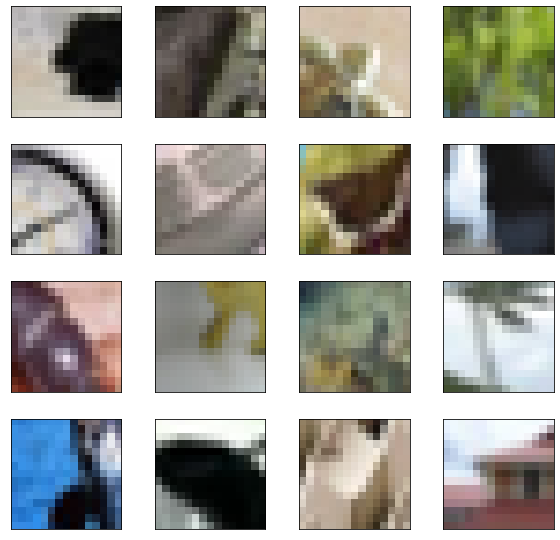

In [67]:
center_patches_umap = []

for c in closest_umap:
    temp_patch = patch_data[c].reshape(1,3,15,15)
    center_patches_umap.append(temp_patch)

center_patches_umap = np.vstack(center_patches_umap)
show_center_patches(center_patches_umap[:16])

Save found patches:

In [68]:
center_patches_umap.shape

(86, 3, 15, 15)

In [69]:
result_path_umap = base_url + patches_layer2_umap_path
with open(result_path_umap, "wb") as fp:
    pickle.dump(center_patches_umap, fp)

Get the k closest patches for each cluster center:

In [70]:
k = 5

In [71]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(86, 48085)

In [72]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([  560, 38988,   850, 16536, 18402, 14802,  3659, 11010, 47615,
       34417, 24794, 42691, 36126,  4615, 37636, 41378,  5329, 42833,
        2720, 46629, 18863, 35316, 28975,  7642, 17800,  6348, 11840,
       17167, 30360, 17360, 46484,  7849, 23819, 34729, 45196, 25123,
       15632, 44944, 27485, 26953,    62, 39517, 28448, 19814, 40422,
       39104, 22137,  6911, 30815,  9401, 29962,  4310,  5977, 19285,
       36878, 19520, 29856, 38192, 37354,  1304, 20184,  4795, 47169,
       18682, 30126, 43653,  8212, 10922, 39503, 41872, 23517, 43736,
        8801, 36909, 23414,    53, 45276, 44078, 18743, 13323,  8782,
       37649, 28367, 30514,  1960, 24083])

Check if we really found the k closest clusters:

In [73]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


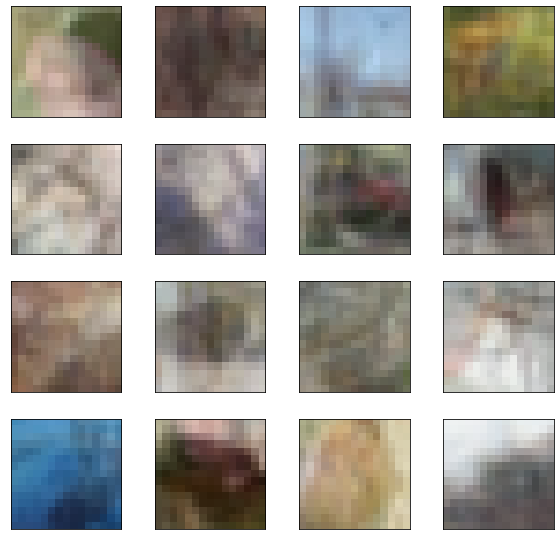

In [74]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [75]:
center_patches_avg_umap.shape

(86, 3, 15, 15)

In [76]:
result_path_avg_umap = base_url + patches_layer2_umap_avg1_path
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)

Get the k closest patches for each cluster center:

In [77]:
k = 10

In [78]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(86, 48085)

In [79]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([  560, 38988,   850, 16536, 18402, 14802,  3659, 11010, 47615,
       34417, 24794, 42691, 36126,  4615, 37636, 41378,  5329, 42833,
        2720, 46629, 18863, 35316, 28975,  7642, 17800,  6348, 11840,
       17167, 30360, 17360, 46484,  7849, 23819, 34729, 45196, 25123,
       15632, 44944, 27485, 26953,    62, 39517, 28448, 19814, 40422,
       39104, 22137,  6911, 30815,  9401, 29962,  4310,  5977, 19285,
       36878, 19520, 29856, 38192, 37354,  1304, 20184,  4795, 47169,
       18682, 30126, 43653,  8212, 10922, 39503, 41872, 23517, 43736,
        8801, 36909, 23414,    53, 45276, 44078, 18743, 13323,  8782,
       37649, 28367, 30514,  1960, 24083])

Check if we really found the k closest clusters:

In [80]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


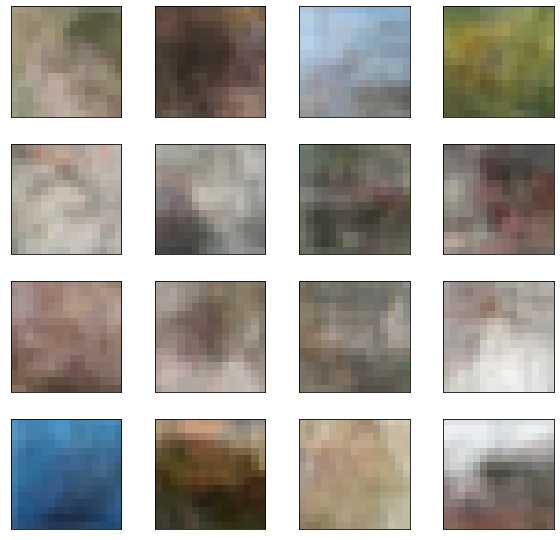

In [81]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [82]:
center_patches_avg_umap.shape

(86, 3, 15, 15)

In [83]:
result_path_avg_umap = base_url + patches_layer2_umap_avg2_path
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)

### Cluster Patches for 3rd layer

In [84]:
num_clusters_layer3 = 342

#### Cluster PCA data

Apply kMeans:

In [85]:
kmeans_pca = KMeans(n_clusters=num_clusters_layer3, random_state=0).fit(patch_data_2d_pca)

Get the closest patch for each cluster center:

In [86]:
closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, patch_data_2d_pca)

tensor shape: (16, 3, 15, 15)


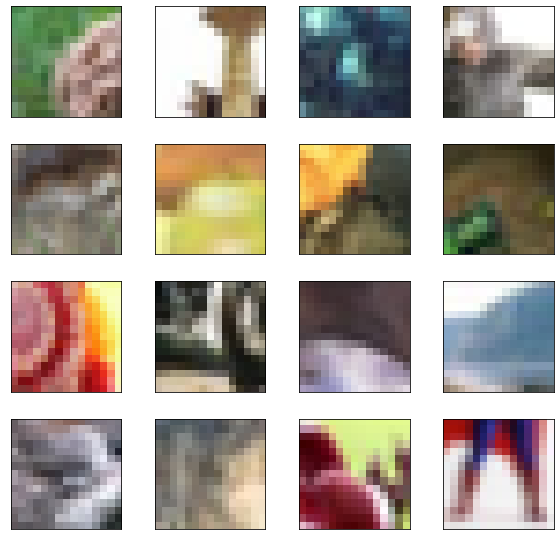

In [87]:
center_patches_pca = []

for c in closest_pca:
    temp_patch = patch_data[c].reshape(1, 3, 15, 15)
    center_patches_pca.append(temp_patch)

center_patches_pca = np.vstack(center_patches_pca)
show_center_patches(center_patches_pca[:16])

Save found patches:

In [88]:
center_patches_pca.shape

(342, 3, 15, 15)

In [89]:
result_path_pca = base_url + patches_layer3_pca_path
with open(result_path_pca, "wb") as fp:
    pickle.dump(center_patches_pca, fp)

Get the k closest patches for each cluster center:

In [90]:
k = 10

In [91]:
distances_pca = pairwise_distances(kmeans_pca.cluster_centers_, patch_data_2d_pca); distances_pca.shape

(342, 155395)

In [92]:
nearest_idx_pca = np.argsort(distances_pca, axis=1)[:,:k]; nearest_idx_pca[:,0]

array([ 94821,  67696, 125268, 147349, 146853, 102311, 126569,  53781,
         1297,  93516,  80298, 152388,  93805, 122986,  71023, 141842,
       149231,  85960,  37606,  86745, 124288,   2572, 112428,  13153,
        96582,  99316,  65861,  84222,  81143,  69105,  17141, 108037,
       115858,  49029,  88969,  65299, 126915, 121346, 142217,  29595,
          580,  35867,  89257, 130910, 128010,  65414,  18488,  99960,
       154845, 138207, 112293, 115368,  34526, 135012,  68618,  62074,
         3319,  26782,  50938, 140282, 118039,  55769, 136557,  95522,
        99121,  41724, 152364,  63620, 120595, 107240,  23782,  58887,
        69164,  32184, 132660, 109415, 139543, 119704,  42948,  18447,
       142619,  78825,  48026, 148897,  48573,  14763,  83457,  10273,
       143730,  46659, 140296, 150269,  25816,  92829,  66045, 101172,
       136395,   2178, 109974, 128896,  64095,  22912,  39729,  24137,
       154317,  61278,  66220,  56525,  30621, 108641, 139854, 153678,
      

Check if we really found the k closest clusters:

In [93]:
for i in range(kmeans_pca.cluster_centers_.shape[0]):
    center_distances = distances_pca[i][nearest_idx_pca[i]]
    farthest = max(center_distances)
    nearer_points = distances_pca[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


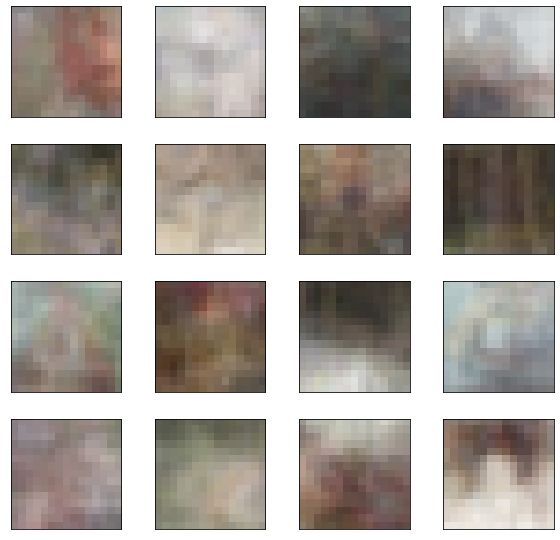

In [94]:
center_patches_avg_pca = []

for c in range(nearest_idx_pca.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_pca.shape[1]):
        temp_idx = nearest_idx_pca[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_pca.shape[1])
    center_patches_avg_pca.append(temp_patch)

center_patches_avg_pca = np.vstack(center_patches_avg_pca)
show_center_patches(center_patches_avg_pca[:16])

Save found average patches:

In [95]:
center_patches_avg_pca.shape

(342, 3, 15, 15)

In [96]:
result_path_avg_pca = base_url + patches_layer3_pca_avg_path
with open(result_path_avg_pca, "wb") as fp:
    pickle.dump(center_patches_avg_pca, fp)

#### Cluster UMAP data

Apply kMeans:

In [97]:
kmeans_umap = KMeans(n_clusters=num_clusters_layer3, random_state=0).fit(patch_data_2d_umap)

Get the closest patch for each cluster center:

In [98]:
closest_umap, _ = pairwise_distances_argmin_min(kmeans_umap.cluster_centers_, patch_data_2d_umap)

tensor shape: (16, 3, 15, 15)


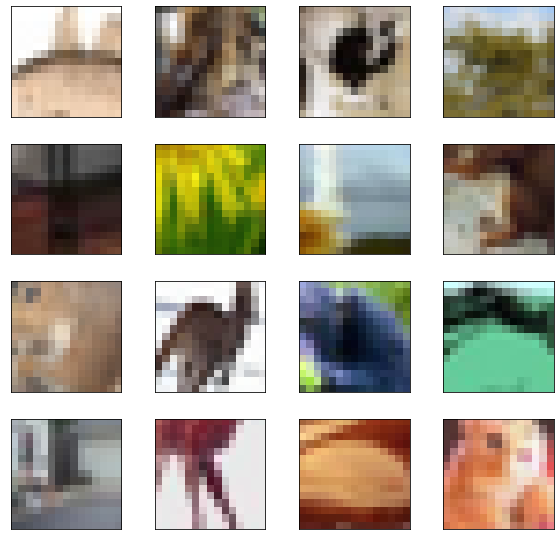

In [99]:
center_patches_umap = []

for c in closest_umap:
    temp_patch = patch_data[c].reshape(1,3,15,15)
    center_patches_umap.append(temp_patch)

center_patches_umap = np.vstack(center_patches_umap)
show_center_patches(center_patches_umap[:16])

Save found patches:

In [100]:
center_patches_umap.shape

(342, 3, 15, 15)

In [101]:
result_path_umap = base_url + patches_layer3_umap_path
with open(result_path_umap, "wb") as fp:
    pickle.dump(center_patches_umap, fp)

Get the k closest patches for each cluster center:

In [102]:
k = 5

In [103]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(342, 48085)

In [104]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([33846,  8510, 44620, 15267,  2644, 39044, 33312, 13036, 35155,
       18205,  7262,  7233,  4348, 21087, 43019, 13987, 35883,  4990,
       25626, 36251,  3140, 22768, 32134, 12956, 36024, 30605, 14882,
       18604, 45211, 37255, 29348,  5473, 31412, 35826,  7692, 26606,
       18750, 37229, 31032, 24820, 45279, 32000, 22007, 47647, 46003,
       18911, 42571, 16144, 14121, 30475, 14233, 46578, 36908, 33030,
       29063,   562, 32201, 11748, 31098,  4323, 44323, 41721, 23307,
       35928, 28108, 14356,  8801, 12585, 24458, 25631, 41350,  1182,
       28529, 44483, 35076,  7798, 37305, 37480, 25928, 27473, 45129,
       16284,  5954, 45958, 15042, 29560, 30720,  6626, 29814, 17139,
        9459, 11662, 25372, 36492,  3334,  4416, 11240, 26013, 29033,
        5541, 34943, 18962, 43340, 31302, 18086, 25801, 30585, 11603,
       11014, 23285, 39261, 25337, 40985,  4618, 19409,   271,  8367,
       18350, 44710, 41728, 15074, 12208, 28048, 26856, 44236, 44519,
       42542, 12370,

Check if we really found the k closest clusters:

In [105]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


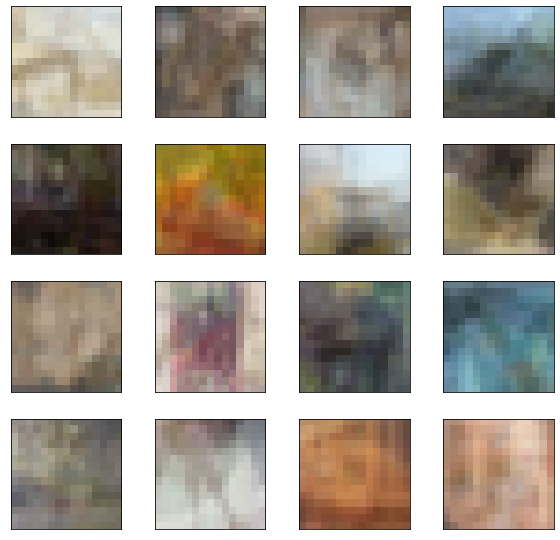

In [106]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [107]:
center_patches_avg_umap.shape

(342, 3, 15, 15)

In [108]:
result_path_avg_umap = base_url + patches_layer3_umap_avg1_path
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)

Get the k closest patches for each cluster center:

In [109]:
k = 10

In [110]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(342, 48085)

In [111]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([33846,  8510, 44620, 15267,  2644, 39044, 33312, 13036, 35155,
       18205,  7262,  7233,  4348, 21087, 43019, 13987, 35883,  4990,
       25626, 36251,  3140, 22768, 32134, 12956, 36024, 30605, 14882,
       18604, 45211, 37255, 29348,  5473, 31412, 35826,  7692, 26606,
       18750, 37229, 31032, 24820, 45279, 32000, 22007, 47647, 46003,
       18911, 42571, 16144, 14121, 30475, 14233, 46578, 36908, 33030,
       29063,   562, 32201, 11748, 31098,  4323, 44323, 41721, 23307,
       35928, 28108, 14356,  8801, 12585, 24458, 25631, 41350,  1182,
       28529, 44483, 35076,  7798, 37305, 37480, 25928, 27473, 45129,
       16284,  5954, 45958, 15042, 29560, 30720,  6626, 29814, 17139,
        9459, 11662, 25372, 36492,  3334,  4416, 11240, 26013, 29033,
        5541, 34943, 18962, 43340, 31302, 18086, 25801, 30585, 11603,
       11014, 23285, 39261, 25337, 40985,  4618, 19409,   271,  8367,
       18350, 44710, 41728, 15074, 12208, 28048, 26856, 44236, 44519,
       42542, 12370,

Check if we really found the k closest clusters:

In [112]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


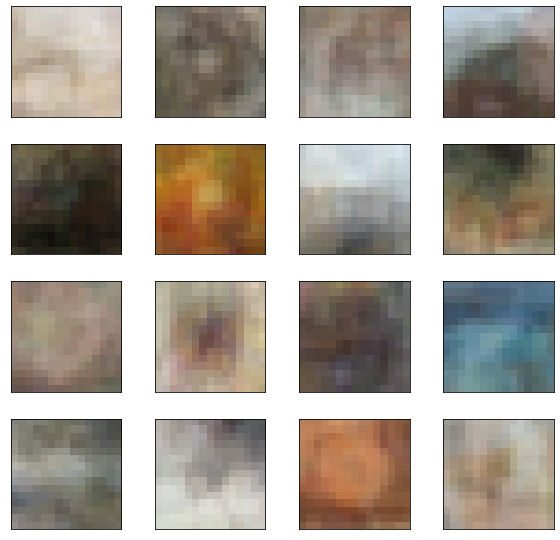

In [113]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [114]:
center_patches_avg_umap.shape

(342, 3, 15, 15)

In [115]:
result_path_avg_umap = base_url + patches_layer3_umap_avg2_path
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)

### Cluster Patches for 4th layer

In [116]:
num_clusters_layer4 = 1366

#### Cluster PCA data

Apply kMeans:

In [117]:
kmeans_pca = KMeans(n_clusters=num_clusters_layer4, random_state=0).fit(patch_data_2d_pca)

Get the closest patch for each cluster center:

In [118]:
closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, patch_data_2d_pca)

tensor shape: (16, 3, 15, 15)


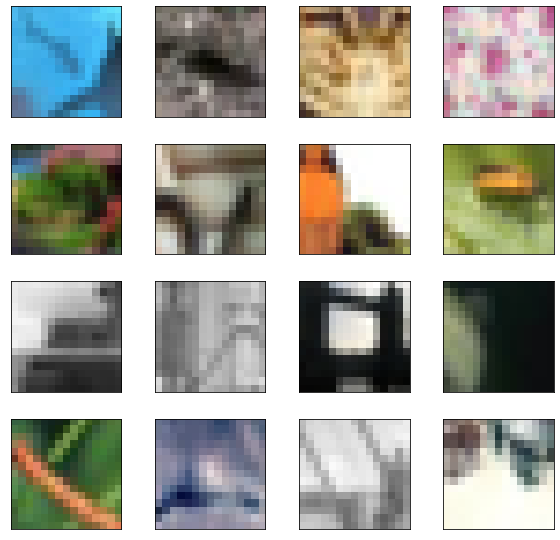

In [119]:
center_patches_pca = []

for c in closest_pca:
    temp_patch = patch_data[c].reshape(1, 3, 15, 15)
    center_patches_pca.append(temp_patch)

center_patches_pca = np.vstack(center_patches_pca)
show_center_patches(center_patches_pca[:16])

Save found patches:

In [120]:
center_patches_pca.shape

(1366, 3, 15, 15)

In [121]:
result_path_pca = base_url + patches_layer4_pca_path
with open(result_path_pca, "wb") as fp:
    pickle.dump(center_patches_pca, fp)

Get the k closest patches for each cluster center:

In [122]:
k = 10

In [123]:
distances_pca = pairwise_distances(kmeans_pca.cluster_centers_, patch_data_2d_pca); distances_pca.shape

(1366, 155395)

In [124]:
nearest_idx_pca = np.argsort(distances_pca, axis=1)[:,:k]; nearest_idx_pca[:,0]

array([ 99784,  24697, 141895, ...,  39619,   3291,  16217])

Check if we really found the k closest clusters:

In [125]:
for i in range(kmeans_pca.cluster_centers_.shape[0]):
    center_distances = distances_pca[i][nearest_idx_pca[i]]
    farthest = max(center_distances)
    nearer_points = distances_pca[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


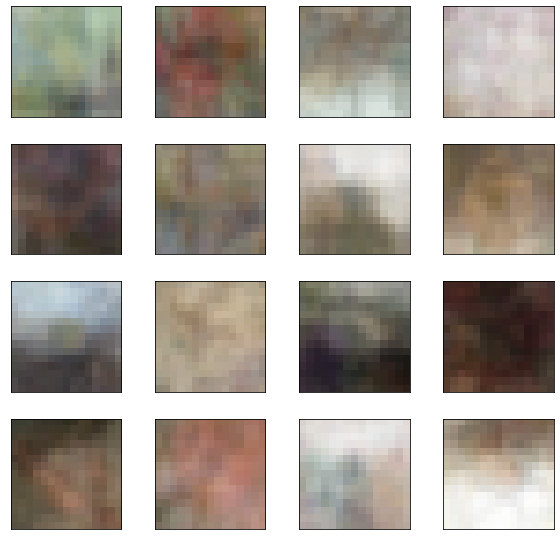

In [126]:
center_patches_avg_pca = []

for c in range(nearest_idx_pca.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_pca.shape[1]):
        temp_idx = nearest_idx_pca[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_pca.shape[1])
    center_patches_avg_pca.append(temp_patch)

center_patches_avg_pca = np.vstack(center_patches_avg_pca)
show_center_patches(center_patches_avg_pca[:16])

Save found average patches:

In [127]:
center_patches_avg_pca.shape

(1366, 3, 15, 15)

In [128]:
result_path_avg_pca = base_url + patches_layer4_pca_avg_path
with open(result_path_avg_pca, "wb") as fp:
    pickle.dump(center_patches_avg_pca, fp)

#### Cluster UMAP data

Apply kMeans:

In [129]:
kmeans_umap = KMeans(n_clusters=num_clusters_layer4, random_state=0).fit(patch_data_2d_umap)

Get the closest patch for each cluster center:

In [130]:
closest_umap, _ = pairwise_distances_argmin_min(kmeans_umap.cluster_centers_, patch_data_2d_umap)

tensor shape: (16, 3, 15, 15)


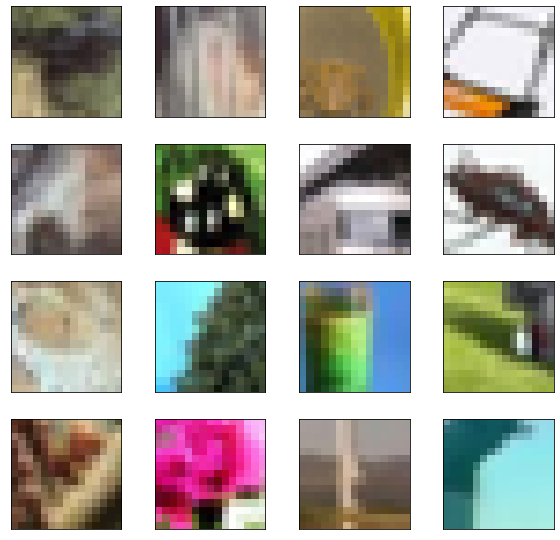

In [131]:
center_patches_umap = []

for c in closest_umap:
    temp_patch = patch_data[c].reshape(1,3,15,15)
    center_patches_umap.append(temp_patch)

center_patches_umap = np.vstack(center_patches_umap)
show_center_patches(center_patches_umap[:16])

Save found patches:

In [132]:
center_patches_umap.shape

(1366, 3, 15, 15)

In [133]:
result_path_umap = base_url + patches_layer4_umap_path
with open(result_path_umap, "wb") as fp:
    pickle.dump(center_patches_umap, fp)

Get the k closest patches for each cluster center:

In [134]:
k = 5

In [135]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(1366, 48085)

In [136]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([37140,  8951, 27505, ...,  6140, 12607, 34658])

Check if we really found the k closest clusters:

In [137]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


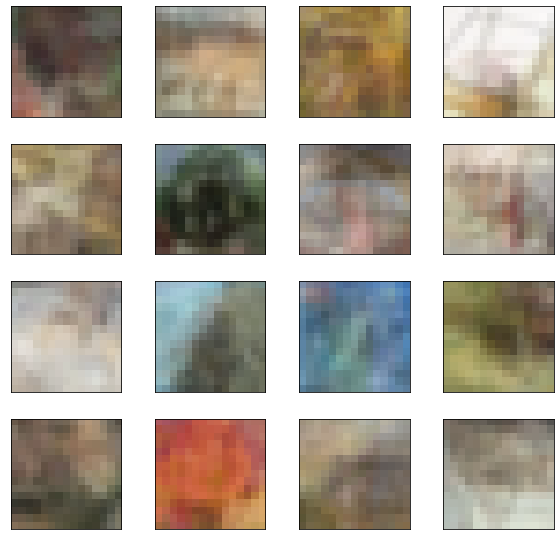

In [138]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [139]:
center_patches_avg_umap.shape

(1366, 3, 15, 15)

In [140]:
result_path_avg_umap = base_url + patches_layer4_umap_avg1_path
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)

Get the k closest patches for each cluster center:

In [141]:
k = 10

In [142]:
distances_umap = pairwise_distances(kmeans_umap.cluster_centers_, patch_data_2d_umap); distances_umap.shape

(1366, 48085)

In [143]:
nearest_idx_umap = np.argsort(distances_umap, axis=1)[:,:k]; nearest_idx_umap[:,0]

array([37140,  8951, 27505, ...,  6140, 12607, 34658])

Check if we really found the k closest clusters:

In [144]:
for i in range(kmeans_umap.cluster_centers_.shape[0]):
    center_distances = distances_umap[i][nearest_idx_umap[i]]
    farthest = max(center_distances)
    nearer_points = distances_umap[i] < farthest
    assert Counter(nearer_points)[True] == (k-1)

Average k closest samples for each cluster:

tensor shape: (16, 3, 15, 15)


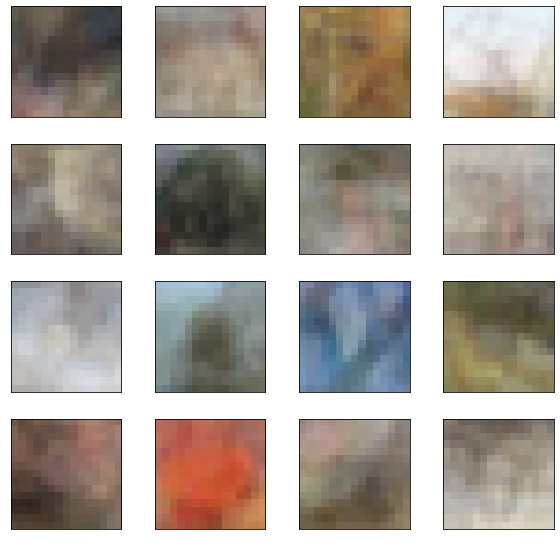

In [145]:
center_patches_avg_umap = []

for c in range(nearest_idx_umap.shape[0]):
    temp_patch = np.zeros((1,3,15,15))

    for s in range(nearest_idx_umap.shape[1]):
        temp_idx = nearest_idx_umap[c,s]
        temp_patch = temp_patch + patch_data[temp_idx].reshape(1,3,15,15)

    temp_patch = temp_patch / (nearest_idx_umap.shape[1])
    center_patches_avg_umap.append(temp_patch)

center_patches_avg_umap = np.vstack(center_patches_avg_umap)
show_center_patches(center_patches_avg_umap[:16])

Save found average patches:

In [146]:
center_patches_avg_umap.shape

(1366, 3, 15, 15)

In [147]:
result_path_avg_umap = base_url + patches_layer4_umap_avg2_path
with open(result_path_avg_umap, "wb") as fp:
    pickle.dump(center_patches_avg_umap, fp)